In [1]:
from fastai.conv_learner import *
from fastai.dataset import *

import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import random
import math
import imgaug as ia
from imgaug import augmenters as iaa

In [2]:
PATH = '/home/baitong/pywork/Humpback/Data/'
TRAIN = PATH+'train/'
TEST = PATH+'test/'
LABELS = PATH+'train.csv'
BOXES = PATH+'bounding_boxes.csv'
MODLE_INIT = PATH+'models/'

n_embedding = 256
bs = 8
ratio = 3
sz0 = 192
sz = (ratio*sz0,sz0)
nw = 2

In [3]:
def open_image(fn):
    flags = cv2.IMREAD_UNCHANGED+cv2.IMREAD_ANYDEPTH+cv2.IMREAD_ANYCOLOR
    if not os.path.exists(fn):
        raise OSError('No such file or directory: {}'.format(fn))
    elif os.path.isdir(fn):
        raise OSError('Is a directory: {}'.format(fn))
    else:
        try:
            im = cv2.imread(str(fn), flags)
            if im is None: raise OSError(f'File not recognized by opencv: {fn}')
            return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        except Exception as e:
            raise OSError('Error handling image at: {}'.format(fn)) from e

class Loader():
    def __init__(self,path,tfms_g=None, tfms_px=None):
        #tfms_g - geometric augmentation (distortion, small rotation, zoom)
        #tfms_px - pixel augmentation and flip
        self.boxes = pd.read_csv(BOXES).set_index('Image')
        self.path = path
        self.tfms_g = iaa.Sequential(tfms_g,random_order=False) \
                        if tfms_g is not None else None
        self.tfms_px = iaa.Sequential(tfms_px,random_order=False) \
                        if tfms_px is not None else None
    def __call__(self, fname):
        fname = os.path.basename(fname)
        x0,y0,x1,y1 = tuple(self.boxes.loc[fname,['x0','y0','x1','y1']].tolist())
        img = open_image(os.path.join(self.path,fname))
        if self.tfms_g != None: img = self.tfms_g.augment_image(img)
        l1,l0,_ = img.shape
        b0,b1 = x1-x0 + 50, y1-y0 + 20 #add extra paddning
        b0n,b1n = (b0, b0/ratio) if b0**2/ratio > b1**2*ratio else (b1*ratio, b1)
        if b0n > l0: b0n,b1n = l0,b1n*l0/b0n
        if b1n > l1: b0n,b1n = b0n*l1/b1n,l1
        x0n = (x0 + x1 - b0n)/2
        x1n = (x0 + x1 + b0n)/2
        y0n = (y0 + y1 - b1n)/2
        y1n = (y0 + y1 + b1n)/2
        x0n,x1n,y0n,y1n = int(x0n),int(x1n),int(y0n),int(y1n)
        if(x0n < 0): x0n,x1n = 0,x1n-x0n
        elif(x1n > l0): x0n,x1n = x0n+l0-x1n,l0
        if(y0n < 0): y0n,y1n = 0,y1n-y0n
        elif(y1n > l1): y0n,y1n = y0n+l1-y1n,l1
        img = cv2.resize(img[y0n:y1n,x0n:x1n,:], sz)
        if self.tfms_px != None: img = self.tfms_px.augment_image(img)
        return img.astype(np.float)/255

In [4]:
class pdFilesDataset(FilesDataset):
    def __init__(self, data, path, transform):
        df = data.copy()
        counts = Counter(df.Id.values)
        df['c'] = df['Id'].apply(lambda x: counts[x])
        #in the production runs df.c>1 should be used
        fnames = df[(df.c>2) & (df.Id != 'new_whale')].Image.tolist()
        df['label'] = df.Id
        df.loc[df.c == 1,'label'] = 'new_whale'
        df = df.sort_values(by=['c'])
        df.label = pd.factorize(df.label)[0]
        l1 = 1 + df.label.max()
        l2 = len(df[df.label==0])
        df.loc[df.label==0,'label'] = range(l1, l1+l2) #assign unique ids
        self.labels = df.copy().set_index('Image')
        self.names = df.copy().set_index('label')
        if path == TRAIN:
            #data augmentation: 8 degree rotation, 10% stratch, shear
            tfms_g = [iaa.Affine(rotate=(-8, 8),mode='reflect',
                scale={"x": (0.9, 1.1), "y": (0.9, 1.1)}, shear=(-8,8))]
            #data augmentation: horizontal flip, hue and staturation augmentation,
            #gray scale, blur
            tfms_px = [iaa.Fliplr(0.5), iaa.AddToHueAndSaturation((-20, 20)),
                iaa.Grayscale(alpha=(0.0, 1.0)),iaa.GaussianBlur((0, 1.0))]
            self.loader = Loader(path,tfms_g,tfms_px)
        else: self.loader = Loader(path)
        super().__init__(fnames, transform, path)
    
    def get_x(self, i):
        label = self.labels.loc[self.fnames[i],'label']
        #random selection of a positive example
        for j in range(10): #sometimes loc call fails
            try:
                names = self.names.loc[label].Image
                break
            except: None
        name_p = names if isinstance(names,str) else \
            random.sample(set(names) - set([self.fnames[i]]),1)[0]
        #random selection of a negative example
        for j in range(10): #sometimes loc call fails
            try:
                names = self.names.loc[self.names.index!=label].Image
                break
            except: None
        name_n = names if isinstance(names,str) else names.sample(1).values[0]
        imgs = [self.loader(os.path.join(self.path,self.fnames[i])),
                self.loader(os.path.join(self.path,name_p)),
                self.loader(os.path.join(self.path,name_n)),
                label,label,self.labels.loc[name_n,'label']]
        return imgs
    
    def get_y(self, i):
        return 0
    
    def get(self, tfm, x, y):
        if tfm is None:
            return (*x,0)
        else:
            x1, y1 = tfm(x[0],x[3])
            x2, y2 = tfm(x[1],x[4])
            x3, y3 = tfm(x[2],x[5])
            #combine all images into one tensor
            x = np.stack((x1,x2,x3),0)
            return x,(y1,y2,y3)
        
    def get_names(self,label):
        names = []
        for j in range(10):
            try:
                names = self.names.loc[label].Image
                break
            except: None
        return names
        
    @property
    def is_multi(self): return True
    @property
    def is_reg(self):return True
    
    def get_c(self): return n_embedding
    def get_n(self): return len(self.fnames)
    
#class for loading an individual images when embedding is computed
class FilesDataset_single(FilesDataset):
    def __init__(self, data, path, transform):
        self.loader = Loader(path)
        fnames = os.listdir(path)
        super().__init__(fnames, transform, path)
        
    def get_x(self, i):
        return self.loader(os.path.join(self.path,self.fnames[i]))
                           
    def get_y(self, i):
        return 0
        
    @property
    def is_multi(self): return True
    @property
    def is_reg(self):return True
    
    def get_c(self): return n_embedding
    def get_n(self): return len(self.fnames)

In [5]:
def get_data(sz,bs):
    tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO)
    tfms[0].tfms = [tfms[0].tfms[2],tfms[0].tfms[3]]
    tfms[1].tfms = [tfms[1].tfms[2],tfms[1].tfms[3]]
    df = pd.read_csv(LABELS)
    trn_df, val_df = train_test_split(df,test_size=0.2, random_state=42)
    ds = ImageData.get_ds(pdFilesDataset, (trn_df,TRAIN), (val_df,TRAIN), tfms)
    md = ImageData(PATH, ds, bs, num_workers=nw, classes=None)
    return md

torch.Size([8, 3, 3, 192, 576]) torch.Size([8])


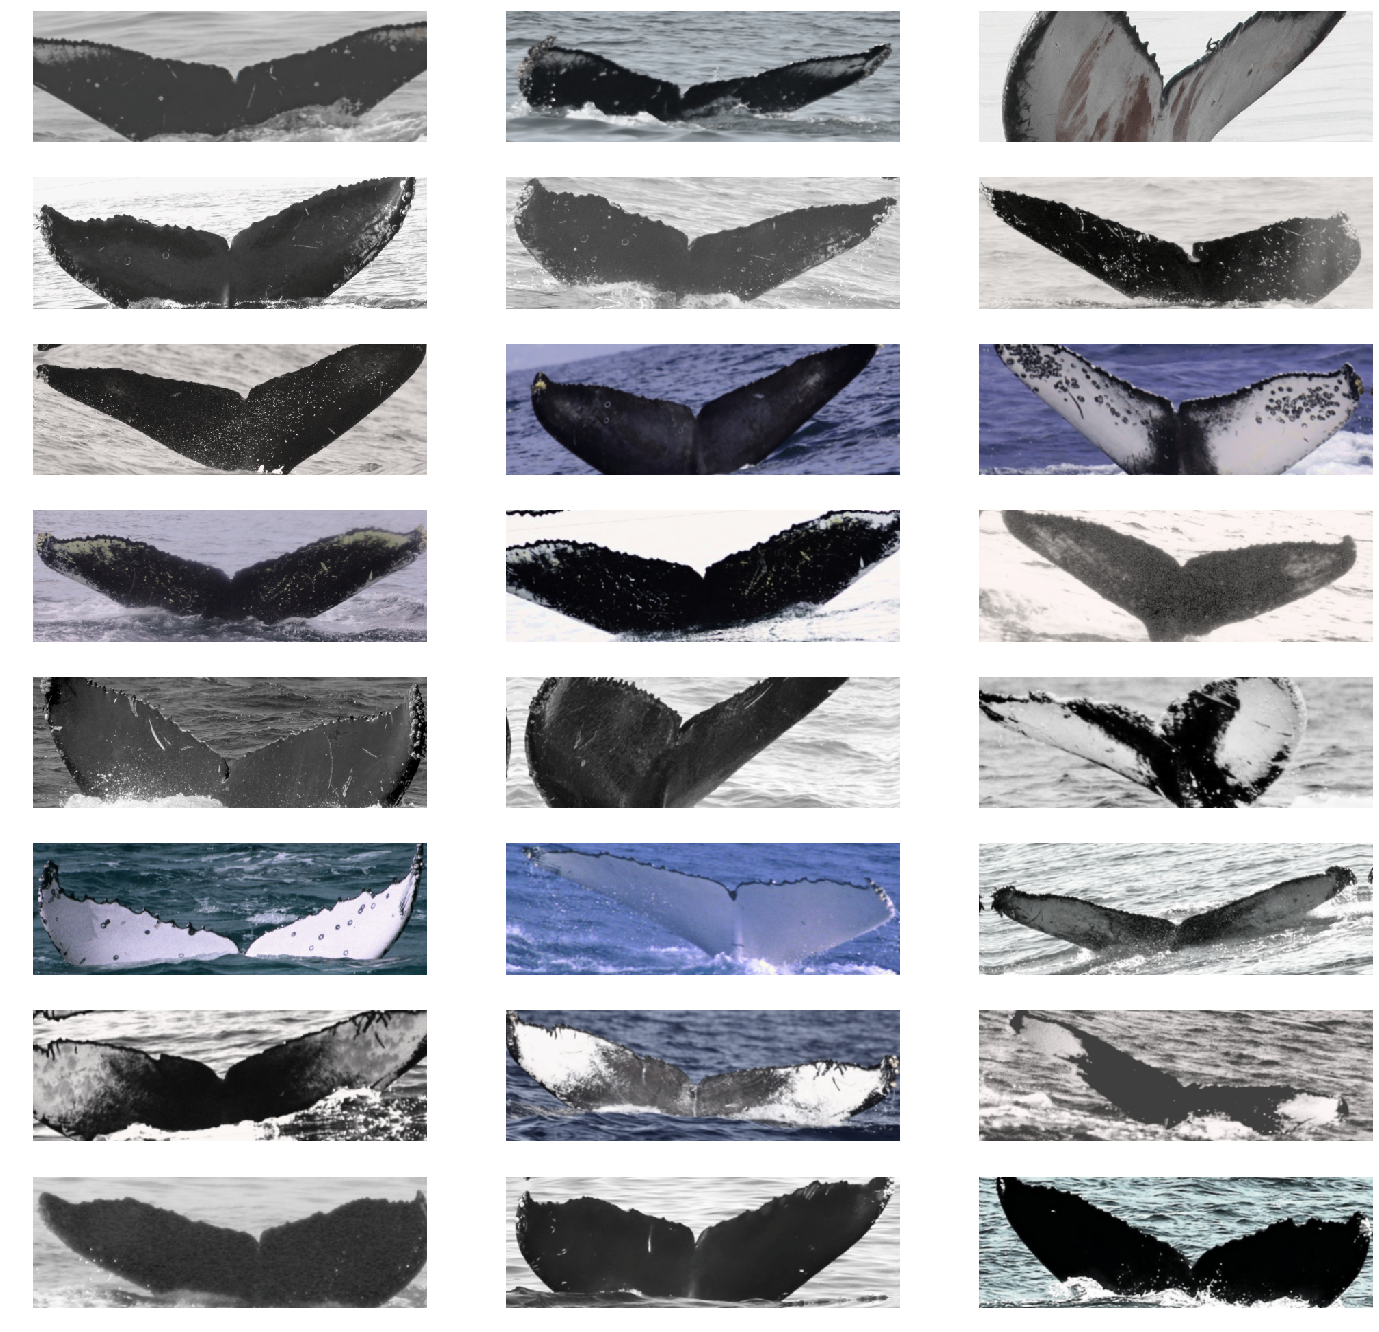

In [6]:
md = get_data(sz,bs)

x,y = next(iter(md.trn_dl))
print(x.shape, y[0].shape)

def display_imgs(x):
    columns = 3
    rows = min(bs,16)
    fig=plt.figure(figsize=(columns*8, rows*3))
    for i in range(rows):
        for j in range(columns):
            idx = j+i*columns
            fig.add_subplot(rows, columns, idx+1)
            plt.axis('off')
            plt.imshow((x[j][i,:,:,:]*255).astype(np.int))
    plt.show()
    
display_imgs((md.trn_ds.denorm(x[:,0,:,:,:]),md.trn_ds.denorm(x[:,1,:,:,:]),md.trn_ds.denorm(x[:,2,:,:,:])))

In [7]:
def resnext50(pretrained=True):
    model = resnext_50_32x4d()
    name = 'resnext_50_32x4d.pth'
    if pretrained:
        path = os.path.join(MODLE_INIT,name)
        load_model(model, path)
    return model

class TripletResneXt50(nn.Module):
    def __init__(self, pre=True, emb_sz=64, ps=0.5):
        super().__init__()
        encoder = resnext50(pretrained=pre)
        self.cnn = nn.Sequential(encoder[0],encoder[1],nn.ReLU(),encoder[3],
                        encoder[4],encoder[5],encoder[6],encoder[7])
        self.head = nn.Sequential(AdaptiveConcatPool2d(), Flatten(), nn.Dropout(ps),
                        nn.Linear(4096, 512), nn.ReLU(), nn.BatchNorm1d(512),
                        nn.Dropout(ps), nn.Linear(512, emb_sz))
        
    def forward(self,x):
        x1,x2,x3 = x[:,0,:,:,:],x[:,1,:,:,:],x[:,2,:,:,:]
        x1 = self.head(self.cnn(x1))
        x2 = self.head(self.cnn(x2))
        x3 = self.head(self.cnn(x3))
        return torch.cat((x1.unsqueeze_(-1),x2.unsqueeze_(-1),x3.unsqueeze_(-1)),dim=-1)
    
    def get_embedding(self, x):
        return self.head(self.cnn(x))
    
class ResNeXt50Model():
    def __init__(self,pre=True,name='TripletResneXt50',**kwargs):
        self.model = to_gpu(TripletResneXt50(pre=True,**kwargs))
        self.name = name

    def get_layer_groups(self, precompute):
        m = self.model.module if isinstance(self.model,FP16) else self.model
        if precompute:
            return [m.head]
        c = children(m.cnn)
        return list(split_by_idxs(c,[5])) + [m.head]

In [8]:
def Contrastive_loss(preds, target, size_average=True, m=10.0):
    #matrix of all vs all comparisons
    t = torch.cat(target)
    sz = t.shape[0]
    t1 = t.unsqueeze(1).expand((sz,sz))
    t2 = t1.transpose(0,1)
    y = t1==t2
    
    pred = torch.cat((preds[:,:,0], preds[:,:,1], preds[:,:,2]))
    half = True if isinstance(pred,torch.cuda.HalfTensor) else False
    if half : pred = pred.float()
    pred1 = pred.unsqueeze(1).expand((sz,sz,-1))
    pred2 = pred1.transpose(0,1)
    d = (pred1 - pred2).pow(2).sum(dim=-1)
    loss_p = d[y==1]
    loss_n = F.relu(m - torch.sqrt(d[y==0]))**2
    loss = torch.cat((loss_p,loss_n),0)
    loss = loss.mean() if size_average else loss.sum()
    if half : pred = pred.half()
    return loss

def DB_acc(preds, target):
    v, p, n = preds[:,:,0], preds[:,:,1], preds[:,:,2]
    dp = (p - v).pow(2).sum(dim=1)
    dn = (n - v).pow(2).sum(dim=1)
    return (dp < dn).float().mean()

In [9]:
learner = ConvLearner(md,ResNeXt50Model(ps=0.0,emb_sz=n_embedding))
learner.opt_fn = optim.Adam
learner.clip = 1.0 #gradient clipping
learner.crit = Contrastive_loss
learner.metrics = [DB_acc]
learner #click "output" to see details of the model

TripletResneXt50(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Sequential(
        (0): LambdaMap(
          (0): Sequential(
            (0): Sequential(
              (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU()
              (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (5): ReLU()
            )
            (1): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        

 85%|████████▌ | 876/1026 [05:18<00:48,  3.08it/s, loss=11.3]

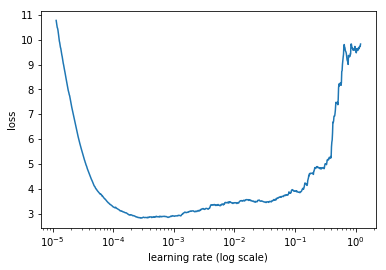

In [10]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learner.lr_find()
learner.sched.plot()

In [12]:
import warnings 
warnings.filterwarnings('ignore')
lr = 2e-4
learner.fit(lr,1)

epoch      trn_loss   val_loss   DB_acc                       
    0      2.354684   3.194691   0.883617  


[3.194690764964214, 0.8836168308501384]

In [13]:
learner.unfreeze()
lrs=np.array([lr/25,lr/5,lr])
learner.half() #

In [14]:
learner.fit(lrs/4,2,cycle_len=1,use_clr=(10,20))
learner.fit(lrs/8,4,cycle_len=2,use_clr=(10,20))
learner.fit(lrs/16,8,cycle_len=2,use_clr=(10,20)) 

epoch      trn_loss   val_loss   DB_acc                       
    0      1.908623   2.472852   0.924799  
    1      1.548069   7.056036   0.96598                      


epoch      trn_loss   val_loss   DB_acc                       
    0      1.378593   2.989064   0.976723  
    1      1.346431   6.523255   0.967771                     
    2      1.276786   3.013521   0.970457                     
    3      1.208172   5.769662   0.966876                     
    4      1.152644   4.353933   0.971352                     
    5      1.096971   1.437354   0.979409                     
    6      1.045525   1.501126   0.984781                      
    7      0.966037   1.990201   0.980304                      


epoch      trn_loss   val_loss   DB_acc                        
    0      0.933459   1.577782   0.983885  
    1      0.937764   1.968248   0.985676                      
    2      0.953659   2.983009   0.975828                      
    3      0.908741   1.853984   0.972247                      
    4      0.86664    1.238809   0.983885                      
    5      0.876356   1.318708   0.980304                      
    6      0.874007   1.729768   0.984781                      
    7      0.979125   1.822141   0.985676                      
    8      0.888338   2.3421     0.984781                      
    9      0.809181   1.537031   0.990152                      
    10     0.78894    1.733929   0.985676                      
    11     0.790301   2.211912   0.982095                      
    12     0.731488   1.43285    0.98299                       
    13     0.806681   2.189021   0.98299                       
    14     0.724039   1.683064   0.98299                    

[1.8954595290557978, 0.9847806624888094]

In [15]:
learner.fit(lrs/32,8,cycle_len=2,use_clr=(10,20)) 

epoch      trn_loss   val_loss   DB_acc                        
    0      0.732303   1.32449    0.987466  
    1      0.744164   1.223909   0.984781                      
    2      0.762134   1.329876   0.991047                      
    3      0.753393   1.35235    0.987466                      
    4      0.754835   1.149284   0.991943                      
    5      0.68349    1.507975   0.982095                      
    6      0.75553    1.403426   0.988362                      
    7      0.728859   1.479896   0.988362                      
    8      0.696673   1.656185   0.987466                      
    9      0.687306   1.11954    0.983885                      
    10     0.691669   1.122618   0.992838                      
    11     0.697281   1.299585   0.985676                      
    12     0.676866   1.402942   0.988362                      
    13     0.722929   1.426594   0.990152                      
    14     0.661572   1.271773   0.989257                   

[1.2567315981018832, 0.9883616830796778]

In [16]:
learner.save('resnext_epoch43')

In [17]:
def extract_embedding(model,path):
    tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO)
    tfms[0].tfms = [tfms[0].tfms[2],tfms[0].tfms[3]]
    tfms[1].tfms = [tfms[1].tfms[2],tfms[1].tfms[3]]
    ds = ImageData.get_ds(FilesDataset_single, (None,TRAIN), (None,TRAIN),
         tfms, test=(None,path))
    md = ImageData(PATH, ds, 3*bs, num_workers=nw, classes=None)
    model.eval()
    with torch.no_grad():
        preds = torch.zeros((len(md.test_dl.dataset), n_embedding))
        start=0
        for i, (x, y) in enumerate(md.test_dl, start=0):
            size = x.shape[0]
            if isinstance(model,FP16):
                preds[start:start+size,:] = model.module.get_embedding(x.half())
            else:
                preds[start:start+size,:] = model.get_embedding(x)
            start+= size
        return preds, [os.path.basename(name) for name in md.test_dl.dataset.fnames]

In [18]:
emb, names = extract_embedding(learner.model,TRAIN)
df = pd.DataFrame({'files':names,'emb':emb.tolist()})
df.emb = df.emb.map(lambda emb: ' '.join(list([str(i) for i in emb])))
df.to_csv('train_emb.csv', header=True, index=False)

In [19]:
emb, names = extract_embedding(learner.model,TEST)
df = pd.DataFrame({'files':names,'emb':emb.tolist()})
df.emb = df.emb.map(lambda emb: ' '.join(list([str(i) for i in emb])))
df.to_csv('test_emb.csv', header=True, index=False)

In [21]:
data = pd.read_csv(LABELS).set_index('Image')
trn_emb = pd.read_csv(os.path.join('../bai/','train_emb.csv'))
trn_emb['emb'] = [[float(i) for i in s.split()] for s in trn_emb['emb']]
trn_emb.set_index('files',inplace=True)
train_df = data.join(trn_emb)
train_df = train_df.reset_index()
train_preds = np.array(train_df.emb.tolist())
#the split should be the same as one used for training.
trn_df, val_df = train_test_split(train_df,test_size=0.2, random_state=42)
trn_preds = np.array(trn_df.emb.tolist())
val_preds = np.array(val_df.emb.tolist())
trn_df = trn_df.reset_index()
val_df = val_df.reset_index()
train_preds.shape

(25361, 256)

In [22]:
neigh = NearestNeighbors(n_neighbors=16)
neigh.fit(trn_preds)
distances_trn, neighbors_trn = neigh.kneighbors(val_preds)

In [23]:
def get_nlabels_trn(idx:int,trn_df,test_df,dcut):
    l0 = test_df.loc[idx].Id
    nbs = dict()
    for i in range(0,16):
        nb = neighbors_trn[idx,i]
        l, d = trn_df.loc[nb].Id, distances_trn[idx,i]
        if d > dcut and 'new_whale' not in nbs: nbs['new_whale'] = dcut
        if l not in nbs: nbs[l] = d
        if len(nbs) >= 5: break
    nbs_sorted = sorted(nbs.items(), key=lambda kv: kv[1])
    score = 0.0
    for i in range(min(len(nbs_sorted),5)):
        if nbs_sorted[i][0] == l0:
            score = 1.0/(i + 1.0)
            break
    return l0, nbs_sorted, score

In [24]:
scores = []
dcut = 3.75
for idx in val_df.index:
    _,_,s = get_nlabels_trn(idx,trn_df,val_df,dcut)
    scores.append(s)
print(np.array(scores).mean())

0.6117681845062093


In [26]:
test_emb = pd.read_csv(os.path.join('../bai/','test_emb.csv'))
test_emb['emb'] = [[float(i) for i in s.split()] for s in test_emb['emb']]
test_emb.set_index('files',inplace=True)
test_df = test_emb.reset_index()
test_preds = np.array(test_df.emb.tolist())
test_df.head()

,files,emb
0,919af8225.jpg,"[0.3936910629272461, -0.16302375495433807, -0...."
1,db9f2937c.jpg,"[0.5153158903121948, 1.192106008529663, -1.312..."
2,7d7079c82.jpg,"[0.31358665227890015, 0.2616174817085266, -0.1..."
3,002f52f0c.jpg,"[-0.5147518515586853, 0.5137861371040344, -0.7..."
4,1877827c6.jpg,"[0.2973421514034271, -0.4728271961212158, -0.2..."


In [27]:
neigh = NearestNeighbors(n_neighbors=16)
neigh.fit(train_preds)
distances_test, neighbors_test = neigh.kneighbors(test_preds)

In [28]:
pred = []
for idx, row in test_df.iterrows():
    nbs = dict()
    for i in range(0,16):
        nb = neighbors_test[idx,i]
        l, d = train_df.loc[nb].Id, distances_test[idx,i]
        if d > dcut and 'new_whale' not in nbs: nbs['new_whale'] = dcut
        if l not in nbs: nbs[l] = d
        if len(nbs) >= 5: break
    nbs_sorted = sorted(nbs.items(), key=lambda kv: kv[1])
    p = ' '.join([lb[0] for lb in nbs_sorted])
    pred.append({'Image':row.files,'Id':p})
pd.DataFrame(pred).to_csv('submission.csv',index=False)